## Récupération données WB

### Data

In [1]:
import pandas as pd
import numpy as np

Paramètres : 

In [2]:
first_year = 1960

country_list=["USA","ARG","BGD","NOR"]  #["BFA","CAN","CHE","DEU","HTI","MLI","NOR","SEN"]
indic_list=["GC.NLD.TOTL.GD.ZS","GE.EST","GC.REV.GOTR.ZS","PV.EST"] #["PV.EST","GE.EST","IQ.CPA.FINQ.XQ","IQ.CPA.DEBT.XQ"]

Processing :

In [3]:

df = pd.read_csv('data/raw_data.csv')

selected_countries = df
#selected_countries = df.loc[df['Country Code'].isin(country_list)]
selected_countries_indicators = selected_countries.loc[selected_countries['Indicator Code'].isin(indic_list)]

selected_countries_indicators = selected_countries_indicators.drop(['Country Name','Indicator Name'], axis=1)

selected_countries_indicators = selected_countries_indicators.drop(selected_countries_indicators.columns[-1], axis=1)

df_melted = pd.melt(selected_countries_indicators, id_vars=['Country Code',"Indicator Code"], var_name='Date', value_name="Value")

contries_date_indic = df_melted.pivot(index=['Country Code', 'Date'], columns='Indicator Code', values='Value').reset_index()

contries_date_indic['Date'] = pd.to_numeric(contries_date_indic['Date'])
contries_date_indic = contries_date_indic[contries_date_indic['Date'] > first_year]

contries_date_indic.columns.name = None

contries_date_indic = contries_date_indic.drop(['Country Code','Date'], axis=1)

data=contries_date_indic.to_numpy()
print(data)



[[        nan         nan         nan         nan]
 [        nan         nan         nan         nan]
 [        nan         nan         nan         nan]
 ...
 [        nan         nan -1.35572577 -1.05272818]
 [        nan         nan -1.30481684 -0.95442593]
 [        nan         nan -1.25461292 -0.88449991]]


### Target: using the CPIA debt policy rating (10=low to 60=high), _IQ.CPA.DEBT.XQ_

In [4]:
target="IQ.CPA.DEBT.XQ"


selected_countries_indicators = selected_countries.loc[selected_countries['Indicator Code']==target]
selected_countries_indicators = selected_countries_indicators.drop(['Country Name','Indicator Name'], axis=1)
selected_countries_indicators = selected_countries_indicators.drop(selected_countries_indicators.columns[-1], axis=1)
df_melted = pd.melt(selected_countries_indicators, id_vars=['Country Code',"Indicator Code"], var_name='Date', value_name="Value")
df_target = df_melted.pivot(index=['Country Code', 'Date'], columns='Indicator Code', values='Value').reset_index()
df_target['Date'] = pd.to_numeric(df_target['Date'])
df_target = df_target[df_target['Date'] > first_year]
df_target.columns.name = None
df_target = df_target.drop(['Country Code','Date'], axis=1)

target = (df_target.values * 10).ravel().astype(int)
target[target < 0] = 0



set_target = set(target)


## Visualisation des données

In [5]:
import matplotlib.pyplot as plt


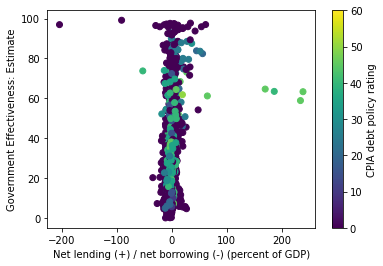

In [6]:
_, ax = plt.subplots()
scatter = ax.scatter(data[:, 0], data[:, 1], c=target, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('CPIA debt policy rating')

ax.set(xlabel="Net lending (+) / net borrowing (-) (percent of GDP)", ylabel="Government Effectiveness: Estimate")
#_ = ax.legend(scatter.legend_elements()[0], [35,40,45], loc="lower right", title="CPIA debt policy rating")
plt.show()

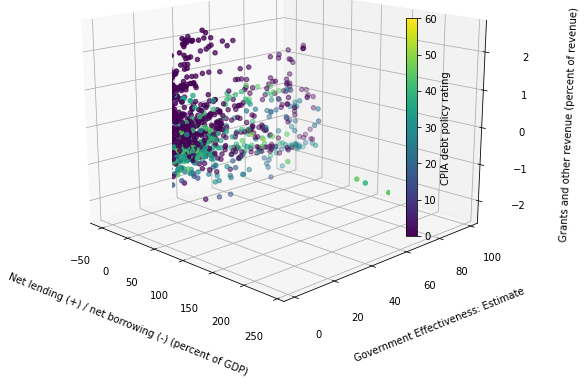

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a 3D scatter plot
scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=target, cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('CPIA debt policy rating')

# Set labels for each axis
ax.set_xlabel("Net lending (+) / net borrowing (-) (percent of GDP)")
ax.set_ylabel("Government Effectiveness: Estimate")
ax.set_zlabel("Grants and other revenue (percent of revenue)")

# Adjust viewing angle and scaling of axes
ax.view_init(elev=15, azim=-45)  # Set the elevation and azimuth angles for viewing
ax.dist = 5

# Show the plot
plt.show()

## First approach of decision tree with SK

In [8]:
#Importation des modules nécessaires
import sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.inspection import DecisionBoundaryDisplay


In [9]:
#Déclaration de l'arbre de décision
clf = DecisionTreeClassifier(max_depth=5)

#Entrainement de l'abre de décision 
clf.fit(data, target)




DecisionTreeClassifier(max_depth=5)

In [10]:
#plot_tree(clf)


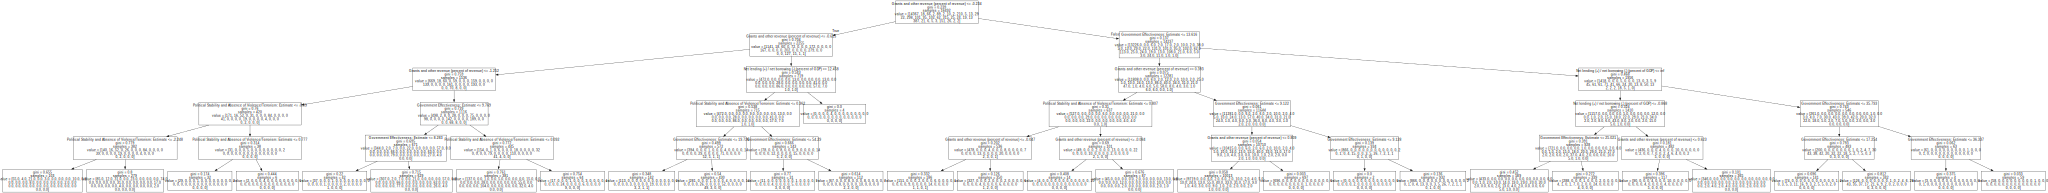

In [11]:
import graphviz
dot_data = export_graphviz(clf, out_file=None, feature_names=["Net lending (+) / net borrowing (-) (percent of GDP)",
                                                              "Government Effectiveness: Estimate",
                                                              "Grants and other revenue (percent of revenue)",
                                                              "Political Stability and Absence of Violence/Terrorism: Estimate"])  
graph = graphviz.Source(dot_data)  
graph 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


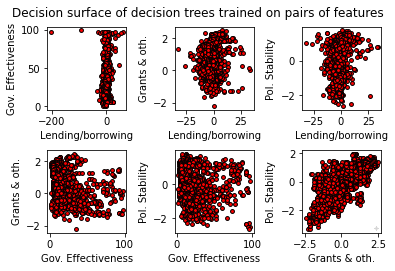

In [12]:
# Parameters
n_classes = len(set_target)
plot_colors = "ryb"
plot_step = 0.02
feature_names=["Lending/borrowing","Gov. Effectiveness","Grants & oth.","Pol. Stability"]

for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = data[:, pair]
    y = target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    ax = plt.subplot(2, 3, pairidx + 1)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.RdYlBu,
        response_method="predict",
        ax=ax,
        xlabel=feature_names[pair[0]],
        ylabel=feature_names[pair[1]],
    )

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(
            X[idx, 0],
            X[idx, 1],
            c=color,
            #label=set_target[i],
            cmap=plt.cm.RdYlBu,
            edgecolor="black",
            s=15,
        )

plt.suptitle("Decision surface of decision trees trained on pairs of features")
plt.legend(loc="lower right", borderpad=0, handletextpad=0)
_ = plt.axis("tight")